### Imports (Libraries & the Dataset)

In [5]:
import pandas as pd
import numpy as np
import squarify
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing the dataset
data = pd.read_csv('Data/purchases.csv')
data.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


### Handling Missing Values

In [3]:
#Checking for the missing values
data.isna().sum()

event_time             0
order_id               0
product_id             0
category_id       431954
category_code     612202
brand             506005
price             431954
user_id          2069352
dtype: int64

In [4]:
#Dataset's length
len(data)

2633521

In [37]:
#Dropping every row with a missing user_id since it's hard to impute and crucial for RFM analysis
data.dropna(subset=['user_id'],inplace=True)
data.isna().sum()

event_time            0
order_id              0
product_id            0
category_id           0
category_code    129370
brand             27224
price                 0
user_id               0
dtype: int64

### Creating A Table For RFM Analysis

Now we can create one dataframe with only the necessary columns we need for the RFM analysis, which would be:

* `event_time` : For retrieving the recency
* `order_id` : For calculating the count of orders by each user
* `product_id` : Every order contains many products. Therefore this is needed to avoid duplicated data situation occured when only order_id exists
* `price` : For calculating the total spend of each customer
* `user_id` : For grouping as a unique identifier

In [43]:
#Creating a new Clean Data Frame with only required features
clean_df = data.drop(['category_id', 'category_code', 'brand'],axis=1)
clean_df.isna().sum()

event_time    0
order_id      0
product_id    0
price         0
user_id       0
dtype: int64

In [81]:
#Getting the total money spent by each customer
total_price = clean_df.groupby(['user_id']).agg({'price':'sum'}).reset_index()
total_price.head()

,user_id,price
0,1515915625439952128,417
1,1515915625440038400,56
2,1515915625440051456,7530
3,1515915625440099840,5074
4,1515915625440121600,183


In [76]:
#Getting the count of orders by each user
order_count = clean_df.groupby(['user_id']).agg({'order_id':'count'}).reset_index()
order_count.head()

,user_id,order_id
0,1515915625439952128,1
1,1515915625440038400,2
2,1515915625440051456,14
3,1515915625440099840,24
4,1515915625440121600,2


In [79]:
#Getting the last order date of each user
last_order_date = clean_df.groupby(['user_id']).agg({'event_time':'last'}).reset_index()
last_order_date.head()

,user_id,event_time
0,1515915625439952128,2020-07-09 06:35:18 UTC
1,1515915625440038400,2020-10-28 05:53:47 UTC
2,1515915625440051456,2020-11-16 15:49:50 UTC
3,1515915625440099840,2020-11-08 23:48:43 UTC
4,1515915625440121600,2020-07-14 13:04:12 UTC


In [90]:
#Checking the length of each grouped by dataframes before merging
groups = ['total_price', 'order_count', 'last_order_date']
for i in range(0,len(groups)):
    var_name = f'{groups[i]}'
    print(f'{groups[i]} has {len(globals()[var_name])} values')

total_price has 98262 values
order_count has 98262 values
last_order_date has 98262 values


Since the 3 tables have the same amount of rows, we can start merging the three tables together and achieve the RFM table.

In [96]:
temp_merge_1 = pd.merge(left = last_order_date, right = order_count, how = 'left', left_on = 'user_id', right_on = 'user_id')
rfm_table = pd.merge(left = temp_merge_1, right = total_price, how = 'left', left_on = 'user_id', right_on= 'user_id')

rfm_table

,user_id,event_time,order_id,price
0,1515915625439952128,2020-07-09 06:35:18 UTC,1,417
1,1515915625440038400,2020-10-28 05:53:47 UTC,2,56
2,1515915625440051456,2020-11-16 15:49:50 UTC,14,7530
3,1515915625440099840,2020-11-08 23:48:43 UTC,24,5074
4,1515915625440121600,2020-07-14 13:04:12 UTC,2,183
...,...,...,...,...
98257,1515915625514887424,2020-11-21 09:13:23 UTC,1,208
98258,1515915625514887936,2020-11-21 09:18:31 UTC,1,3472
98259,1515915625514888704,2020-11-21 10:10:01 UTC,3,752
98260,1515915625514891008,2020-11-21 10:04:42 UTC,1,926


In [110]:
rfm_table.describe()

,user_id,order_id,price
count,98262,98262,98262
mean,1515915625477892608,6,1196
std,22999554,26,3839
min,1515915625439952128,1,0
25%,1515915625457236992,1,139
50%,1515915625477450752,2,433
75%,1515915625497920768,4,1094
max,1515915625514891264,635,121701


We can create a SQLite Database to store these dataframes prepared for the re-usability

In [97]:
#Let's create a SQL database and store this RFM table clean data there
import sqlite3
conn = sqlite3.connect('RFM_DB')
cur = conn.cursor()

rfm_table.to_sql('agg_transactions', conn, if_exists='replace', index=False)

98262

In [98]:
pd.read_sql('SELECT * FROM agg_transactions LIMIT 11;', conn)

,user_id,event_time,order_id,price
0,1515915625439952128,2020-07-09 06:35:18 UTC,1,417
1,1515915625440038400,2020-10-28 05:53:47 UTC,2,56
2,1515915625440051456,2020-11-16 15:49:50 UTC,14,7530
3,1515915625440099840,2020-11-08 23:48:43 UTC,24,5074
4,1515915625440121600,2020-07-14 13:04:12 UTC,2,183
5,1515915625440881408,2020-11-16 10:27:57 UTC,37,22917
6,1515915625440936192,2020-11-06 14:52:05 UTC,10,5006
7,1515915625440936704,2020-09-16 10:35:47 UTC,34,12186
8,1515915625440936960,2020-11-15 12:04:38 UTC,11,10563
9,1515915625440937216,2020-11-14 12:46:44 UTC,62,10937


### Creating the RFM Table

In [99]:
#Let's make the RFM levels
query = '''
SELECT user_id, rfm_recency, rfm_frequency, rfm_monetary, rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined
FROM(
    SELECT user_id,
        NTILE(4) OVER (ORDER BY event_time) AS rfm_recency,
        NTILE(4) OVER (ORDER BY order_id) AS rfm_frequency,
        NTILE(4) OVER (ORDER BY price) AS rfm_monetary
    FROM agg_transactions
);
'''

In [104]:
rfm_score = pd.read_sql(query, conn)
rfm_score.head()

,user_id,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined
0,1515915625447103744,1,1,1,111
1,1515915625481510912,1,1,1,111
2,1515915625446834944,1,1,1,111
3,1515915625473075968,1,1,1,111
4,1515915625444251392,1,1,1,111


### Assigning each Customer to Pre-Defined Segments Based on RFM Score

Now that we have the rfm scores and the combined rfm value, We can divide each customer into groups that are easy to detect. The logic used for dividing into groups will be as follows:

* Best customers: R>=4, F>=4, M>=4
* Loyal: R>=3, F>=3, M>=3
* Potential Loyalist: R>=3, F>=1, M>=2
* Promising: R>=3, F>=1, M>=1
* Customers Needing Attention: R>=2, F>=2, M>=2
* At Risk: R>=1, F>=2, M>=2
* Hibernating: R>=1, F>=1, M>=2
* Else Lost

In [105]:
def grouping_func(rfm_tb):
    if (rfm_tb['rfm_recency'] >=4) and (rfm_tb['rfm_frequency'] >=4) and (rfm_tb['rfm_monetary'] >=4):
        return "Best Customer"
    elif (rfm_tb['rfm_recency'] >=3) and (rfm_tb['rfm_frequency'] >=3) and (rfm_tb['rfm_monetary'] >=3):
        return "Loyal Customer"
    elif (rfm_tb['rfm_recency'] >=4) and (rfm_tb['rfm_frequency'] >=1) and (rfm_tb['rfm_monetary'] >=2):
        return "Potential Loyal Customer"
    elif (rfm_tb['rfm_recency'] >=3) and (rfm_tb['rfm_frequency'] >=1) and (rfm_tb['rfm_monetary'] >=1):
        return "Promising Customer"
    elif (rfm_tb['rfm_recency'] >=2) and (rfm_tb['rfm_frequency'] >=2) and (rfm_tb['rfm_monetary'] >=2):
        return "Customer Needs Attention"
    elif (rfm_tb['rfm_recency'] >=1) and (rfm_tb['rfm_frequency'] >=2) and (rfm_tb['rfm_monetary'] >=2):
        return "At Risk"
    elif (rfm_tb['rfm_recency'] >=1) and (rfm_tb['rfm_frequency'] >=1) and (rfm_tb['rfm_monetary'] >=2):
        return "Hibernating"
    else:
        return "Lost"

In [106]:
#Applying the defined function
rfm_score['rfm_level'] = rfm_score.apply(grouping_func, axis=1)
rfm_score

,user_id,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,1515915625447103744,1,1,1,111,Lost
1,1515915625481510912,1,1,1,111,Lost
2,1515915625446834944,1,1,1,111,Lost
3,1515915625473075968,1,1,1,111,Lost
4,1515915625444251392,1,1,1,111,Lost
...,...,...,...,...,...,...
98257,1515915625470243072,4,3,2,432,Potential Loyal Customer
98258,1515915625513809920,4,4,4,444,Best Customer
98259,1515915625514888704,4,3,3,433,Loyal Customer
98260,1515915625514891264,4,2,2,422,Potential Loyal Customer


### A Tree Map to Visualize Segments

Let's create a tree map to see the distribution of our customers in each group

In [108]:
bin_vals = rfm_score['rfm_level'].value_counts().reset_index()
bin_vals

,rfm_level,count
0,Loyal Customer,18849
1,Lost,17204
2,Customer Needs Attention,16233
3,Promising Customer,15733
4,At Risk,11023
5,Best Customer,8620
6,Potential Loyal Customer,5928
7,Hibernating,4672


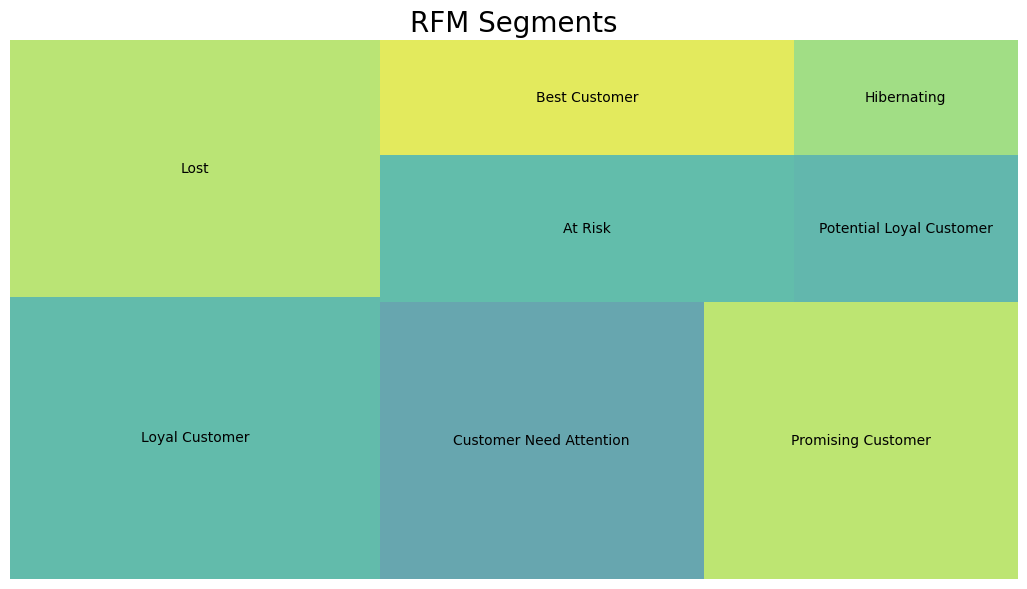

In [109]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=bin_vals['count'], 
              label=['Loyal Customer',
                     'Lost',
                     'Customer Need Attention',
                     'Promising Customer',
                     'At Risk',
                     'Best Customer',
                     'Potential Loyal Customer',        
                     'Hibernating'], alpha=0.7)
plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()

### Extra:

Not directly related to the RFM Analysis. Consider as rough work

This is to display the scientific number format numbers in the general format

In [68]:
pd.options.display.float_format = '{:.0f}'.format

In [93]:
clean_df[clean_df['user_id'] == 1515915625440121600]

,event_time,order_id,product_id,price,user_id
9797,2020-05-16 16:09:13 UTC,2310435145397568049,1515966223509089642,44,1515915625440121600
1019180,2020-07-14 13:04:12 UTC,2353103784764244740,1515966223509088620,139,1515915625440121600
